In [1]:
import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tvt

from PIL import Image
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from pytorch_fid.inception import InceptionV3
from pytorch_fid.fid_score import (
    calculate_activation_statistics,
    calculate_frechet_distance,
)

# setting seeds for consistency (reference: Lecture 2 and HW 2)
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmarks = False
os.environ["PYTHONHASHSEED"] = str(seed)

data_dir = "./dataset"

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

torch.cuda.set_device("cuda:0")

dataset = datasets.ImageFolder(
    root=data_dir,
    transform=tvt.Compose(
        [tvt.ToTensor(), tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    ),
)

batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size)

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 4-2-1
        self.conv1 = nn.Conv2d(3, 16, 4, 2, 1)
        self.conv2 = nn.Conv2d(16, 32, 4, 2, 1)
        self.conv3 = nn.Conv2d(32, 64, 4, 2, 1)
        self.conv4 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv5 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv_final = nn.Conv2d(256, 1, 2, 1, 0)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1, True)
        x = self.bn1(self.conv2(x))
        x = F.leaky_relu(x, 0.1, True)
        x = self.bn2(self.conv3(x))
        x = F.leaky_relu(x, 0.1, True)
        x = self.bn3(self.conv4(x))
        x = F.leaky_relu(x, 0.1, True)
        x = self.bn4(self.conv5(x))
        x = F.leaky_relu(x, 0.1, True)
        x = self.out(self.conv_final(x))
        return x


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.convtrans1 = nn.ConvTranspose2d(100, 256, 2, 1, 0, bias=False)
        self.convtrans2 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.convtrans3 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.convtrans4 = nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False)
        self.convtrans5 = nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False)
        self.convtrans_final = nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(16)
        self.out = nn.Tanh()

    def forward(self, x):
        x = self.convtrans1(x)
        x = F.leaky_relu(self.bn1(x), negative_slope=0.1)
        x = self.convtrans2(x)
        x = F.leaky_relu(self.bn2(x), negative_slope=0.1)
        x = self.convtrans3(x)
        x = F.leaky_relu(self.bn3(x), negative_slope=0.1)
        x = self.convtrans4(x)
        x = F.leaky_relu(self.bn4(x), negative_slope=0.1)
        x = self.convtrans5(x)
        x = F.leaky_relu(self.bn5(x), negative_slope=0.1)
        x = self.out(self.convtrans_final(x))
        return x

In [3]:
def training(discriminator, generator, dataloader, results_dir, device):

    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find("BatchNorm") != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    nz = 100

    netD = discriminator.to(device).apply(weights_init)
    netG = generator.to(device).apply(weights_init)

    fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

    real_label, fake_label = 1, 0

    optimD = torch.optim.Adam(netD.parameters(), lr=1e-4, betas=(0.75, 0.999))
    optimG = torch.optim.Adam(netG.parameters(), lr=1e-4, betas=(0.75, 0.999))

    criterion = nn.BCELoss()

    image_lists = []
    G_losses = []
    D_losses = []
    iterations = 0
    print("\n\nStarting Training Loop....\n\n")

    for epoch in range(500):
        g_losses_per_print = []
        d_losses_per_print = []
        for i, data in enumerate(dataloader, 0):
            netD.zero_grad()
            real_images = data[0].to(device)

            label = torch.full(
                (batch_size,), real_label, device=device, dtype=torch.float
            )
            output = netD(real_images).view(-1)
            lossD_real = criterion(output, label)
            lossD_real.backward()

            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            label.fill_(fake_label)
            output = netD(fake_images.detach()).view(-1)
            lossD_fakes = criterion(output, label)
            lossD_fakes.backward()

            overall_lossD = lossD_real + lossD_fakes
            d_losses_per_print.append(overall_lossD)
            optimD.step()

            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake_images).view(-1)
            lossG = criterion(output, label)
            g_losses_per_print.append(lossG)
            lossG.backward()
            optimG.step()

            if i % 500 == 499:
                average_dloss = torch.mean(torch.FloatTensor(d_losses_per_print)).cpu()
                average_gloss = torch.mean(torch.FloatTensor(g_losses_per_print)).cpu()
                print(
                    "Epoch:",
                    epoch + 1,
                    "=> ",
                    "Discriminator Loss:",
                    torch.round(average_dloss, decimals=6),
                    "Generator Loss:",
                    torch.round(average_gloss, decimals=6),
                )

            G_losses.append(lossG.item())
            D_losses.append(overall_lossD.item())

            if (i % 1000 == 0) or ((epoch == 499) and (i == len(dataloader) - 1)):
                if not os.path.exists(results_dir):
                    os.mkdir(results_dir)
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                image = tvt.ToPILImage()(
                    make_grid(fake, padding=1, pad_value=1, normalize=True)
                )
                image.save(results_dir + str(epoch) + "_" + str(i) + ".jpg", "JPEG")

            iterations += 1

    return G_losses, D_losses

In [4]:
discriminator = Discriminator()
generator = Generator()

num_learnable_params_disc = sum(
    p.numel() for p in discriminator.parameters() if p.requires_grad
)
print(
    "\n\nThe number of learnable parameters in the Discriminator: %d\n"
    % num_learnable_params_disc
)
num_learnable_params_gen = sum(
    p.numel() for p in generator.parameters() if p.requires_grad
)
print(
    "\nThe number of learnable parameters in the Generator: %d\n"
    % num_learnable_params_gen
)
num_layers_disc = len(list(discriminator.parameters()))
print("\nThe number of layers in the discriminator: %d\n" % num_layers_disc)
num_layers_gen = len(list(generator.parameters()))
print("\nThe number of layers in the generator: %d\n\n" % num_layers_gen)



The number of learnable parameters in the Discriminator: 699569


The number of learnable parameters in the Generator: 800480


The number of layers in the discriminator: 20


The number of layers in the generator: 16




In [5]:
G_losses, D_losses = training(
    discriminator, generator, dataloader, "./results/", device
)



Starting Training Loop....


Epoch: 1 =>  Discriminator Loss: tensor(0.0621) Generator Loss: tensor(5.6866)
Epoch: 1 =>  Discriminator Loss: tensor(0.1622) Generator Loss: tensor(5.2211)
Epoch: 2 =>  Discriminator Loss: tensor(0.3014) Generator Loss: tensor(4.2993)
Epoch: 2 =>  Discriminator Loss: tensor(0.3929) Generator Loss: tensor(3.9306)
Epoch: 3 =>  Discriminator Loss: tensor(0.5228) Generator Loss: tensor(3.3278)
Epoch: 3 =>  Discriminator Loss: tensor(0.5397) Generator Loss: tensor(3.1631)
Epoch: 4 =>  Discriminator Loss: tensor(0.5926) Generator Loss: tensor(2.9881)
Epoch: 4 =>  Discriminator Loss: tensor(0.5926) Generator Loss: tensor(2.9517)
Epoch: 5 =>  Discriminator Loss: tensor(0.5170) Generator Loss: tensor(3.2380)
Epoch: 5 =>  Discriminator Loss: tensor(0.5216) Generator Loss: tensor(3.2172)
Epoch: 6 =>  Discriminator Loss: tensor(0.5240) Generator Loss: tensor(3.1019)
Epoch: 6 =>  Discriminator Loss: tensor(0.5123) Generator Loss: tensor(3.1686)
Epoch: 7 =>  Discrimi

In [12]:
torch.save(generator.state_dict(), "./gen.pth")
torch.save(discriminator.state_dict(), "./dis.pth")

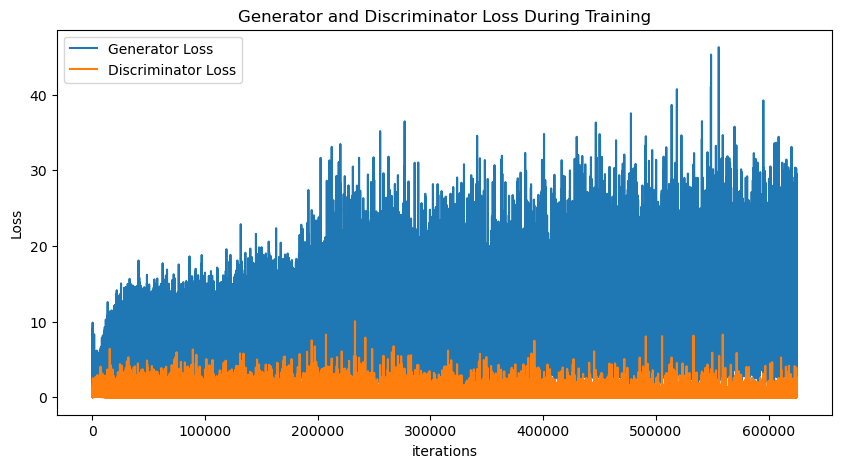

In [6]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./gen_and_disc_loss_training.png")
plt.show()

In [7]:
gen_testing_net = Generator()
gen_testing_net.load_state_dict(torch.load("./gen.pth"))
gen_testing_net = gen_testing_net.to(device)

for i in range(2048):
    nz = 100
    fixed_noise = torch.randn(1, nz, 1, 1, device=device)
    transform = tvt.Compose(
        [
            tvt.Normalize((0.0, 0.0, 0.0), (2.0, 2.0, 2.0)),
            tvt.Normalize((-0.5, -0.5, -0.5), (1, 1, 1)),
            tvt.ToPILImage(),
        ]
    )
    fake_img = transform(
        torch.squeeze((gen_testing_net(fixed_noise).detach().cpu()), dim=0)
    )
    fake_img.save("./fake_images/" + str(i) + ".jpeg", "JPEG")

In [8]:
real_paths = []
fake_paths = []

paths = os.listdir("./real_images")
for path in paths:
    path = "./real_images/" + path
    real_paths.append(path)
paths = os.listdir("./fake_images")
for path in paths:
    path = "./fake_images/" + path
    fake_paths.append(path)

dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device=device)
m1, s1 = calculate_activation_statistics(real_paths, model, device=device)
m2, s2 = calculate_activation_statistics(fake_paths, model, device=device)
fid_value = calculate_frechet_distance(m1, s1, m2, s2)
print(f"FID: {fid_value:.2f}")

100%|██████████| 41/41 [00:09<00:00,  4.40it/s]


FID: 144.74


In [14]:
real_paths = []
fake_paths = []

paths = os.listdir("./real_images")
for path in paths:
    path = "./real_images/" + path
    real_paths.append(path)
paths = os.listdir("./visualize_samples")
for path in paths:
    path = "./visualize_samples/" + path
    fake_paths.append(path)

dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device=device)
m1, s1 = calculate_activation_statistics(real_paths, model, device=device)
m2, s2 = calculate_activation_statistics(fake_paths, model, device=device)
fid_value = calculate_frechet_distance(m1, s1, m2, s2)
print(f"FID: {fid_value:.2f}")

2048
2048


100%|██████████| 41/41 [00:09<00:00,  4.54it/s]


FID: 130.95
